# IMAGINE tutorial 4 --  data masking

### Or how to mask the datasets easily.  

For users who do not want to simulate and fit a full sky map (e.g., to remove confusing regions) or who need patches of a HEALPix map at high resolution, IMAGINE has a Masks class derived from **ObservableDict**.  **hammurabiX** provides galactic longitude/latitude limit controllers, but the Masks class is more flexible.  It also applies the masks correctly not only to the simulation but also the measured data sets and the corresponding observational covariances.  

In [1]:
%matplotlib inline

import numpy as np
import healpy as hp

from imagine.observables.observable_dict import Measurements, Simulations, Covariances, Masks
from imagine.simulators.hammurabi.hammurabi import Hammurabi
from imagine.fields.breg_wmap.hamx_field import BregWMAP
from imagine.fields.cre_analytic.hamx_field import CREAna
from imagine.fields.fereg_ymw16.hamx_field import FEregYMW16

First of all, make an example, let's mask out low latitude ($ |l| < 20^\circ $) pixels and those inside four local loops

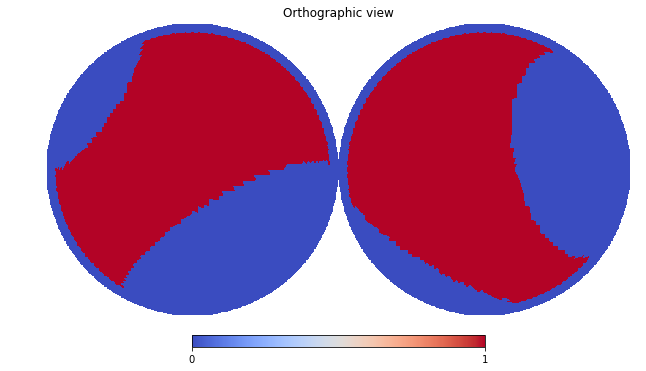

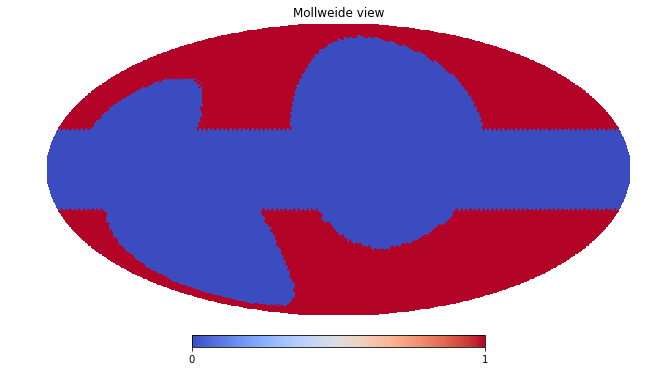

In [2]:
mask_nside = 32

# mask loops and latitude
def mask_map_val(_nside,_ipix):
    l,b = hp.pix2ang(_nside,_ipix,lonlat=True)
    R = np.pi/180.
    cue = 1
    L = [329,100,124,315]
    B = [17.5,-32.5,15.5,48.5]
    D = [116,91,65,39.5]
    #LOOP I
    if( np.arccos(np.sin(b*R)*np.sin(B[0]*R)+np.cos(b*R)*np.cos(B[0]*R)*np.cos(l*R-L[0]*R))<0.5*D[0]*R ):
        cue = 0
    #LOOP II
    if( np.arccos(np.sin(b*R)*np.sin(B[1]*R)+np.cos(b*R)*np.cos(B[1]*R)*np.cos(l*R-L[1]*R))<0.5*D[1]*R ):
        cue = 0
    #LOOP III
    if( np.arccos(np.sin(b*R)*np.sin(B[2]*R)+np.cos(b*R)*np.cos(B[2]*R)*np.cos(l*R-L[2]*R))<0.5*D[2]*R ):
        cue = 0
    #LOOP IV
    if( np.arccos(np.sin(b*R)*np.sin(B[3]*R)+np.cos(b*R)*np.cos(B[3]*R)*np.cos(l*R-L[3]*R))<0.5*D[3]*R ):
        cue = 0
    #STRIPE
    if(abs(b)<20.):
        cue = 0
    return cue

mask_map = np.zeros(hp.nside2npix(mask_nside))

for i in range(len(mask_map)):
    mask_map[i] = mask_map_val(mask_nside, i)

hp.orthview(mask_map, cmap='coolwarm', rot=(0,90))

hp.mollview(mask_map, cmap='coolwarm')

as **Masks** is derived from **ObservableDict**, its object creation is the same as **Measurements**

In [3]:
msk_dict = Masks()

msk_dict.append(('sync', '23', '32', 'I'), np.vstack([mask_map]))

**Masks** object, or the mask map dictionary is invoked in **Likelihood** initialisation

where input **Measurements** and **Covariances** objects will be manipulated

then in **Pipeline**, **Simulations** objects produced by a **Simulator** object will be processed in the same way

here we illustrate what actually happens to observables

fist, we need an observable dictionary

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '32'}
|-->  faraday {'cue': '1', 'nside': '16'}
|-->  dm {'cue': '1', 'nside': '8'}
dict_keys([('sync', '23', '32', 'I'), ('fd', 'nan', '16', 'nan'), ('dm', 'nan', '8', 'nan')])


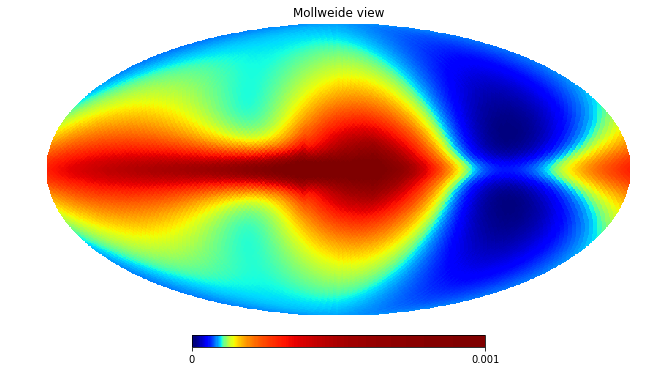

In [4]:
# empty measuremnts
arr32 = np.zeros((1, 12*32**2))
arr16 = np.zeros((1, 12*16**2))
arr8 = np.zeros((1, 12*8**2))
measuredict = Measurements()
measuredict.append(('sync', '23', '32', 'I'), arr32)  # healpix map
measuredict.append(('fd', 'nan', '16', 'nan'), arr16)
measuredict.append(('dm', 'nan', '8', 'nan'), arr8)
# consider only init, hammurabi executable is not necessary
xmlpath = './template.xml'
simer = Hammurabi(measurements=measuredict,xml_path=xmlpath)

# ensemble size
ensemble_size = 1

# BregWMAP field
paramlist = {'b0': 6.0, 'psi0': 27.9, 'psi1': 1.3, 'chi0': 24.6}
breg_wmap = BregWMAP(paramlist, ensemble_size)
# CREAna field
paramlist = {'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
             'r0': 5.6, 'z0': 1.2,
             'E0': 20.5,
             'j0': 0.03}
cre_ana = CREAna(paramlist, ensemble_size)
# FEregYMW16 field
paramlist = dict()
fereg_ymw16 = FEregYMW16(paramlist, ensemble_size)

# push fields to simulator
simer.register_fields([breg_wmap, cre_ana, fereg_ymw16])

maps = simer([breg_wmap, cre_ana, fereg_ymw16])

print (maps.keys())

unmasked = maps[('sync','23','32','I')].to_global_data()

hp.mollview(unmasked[0], norm='hist', cmap='jet', min=0, max=1.0e-3)

then apply the mask defined in the beginning, **only** to intensity map as defined

<span style="color:red">**apply_mask function will not act twice to the same map**</span>

check closely to the following printing info, the Nside attribute value of masked has been changed to Npix

and, consequently, the HEALPix map has been re-registered as a plain data

dict_keys([('fd', 'nan', '16', 'nan'), ('dm', 'nan', '8', 'nan'), ('sync', '23', '4941', 'I')])


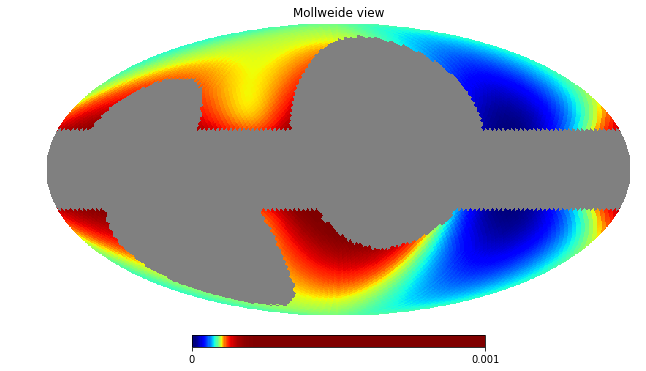

In [5]:
maps.apply_mask(msk_dict)

print (maps.keys())

raw_map = maps[('sync','23','4941','I')].to_global_data()

masked = np.zeros(hp.nside2npix(mask_nside))

idx = int(0)
for i in range(len(mask_map)):
    if mask_map[i] == 0:
        masked[i] = hp.UNSEEN
    else:
        masked[i] = raw_map[0,idx]
        idx += int(1)

hp.mollview(masked, norm='hist', cmap='jet', min=0, max=1.0e-3)

# correctness check
for i in range(len(masked)):
    if mask_map[i] == 1 and masked[i] - unmasked[0][i] != 0:
        print ('incorrect mask')